# Tech Challenge Fase 4 — Modelo LSTM para Previsão de Preços de Ações

**Empresa escolhida:** Petrobras (PETR4.SA)  
**Objetivo:** Criar um modelo preditivo de redes neurais Long Short Term Memory (LSTM) para predizer o valor de fechamento da bolsa de valores da Petrobras, cobrindo toda a pipeline: coleta, pré-processamento, análise exploratória, análise de séries temporais, modelagem LSTM e exportação do modelo.

---

## Sumário

1. [Instalação e Importações](#1-instalacao)
2. [Coleta e Pré-processamento dos Dados](#2-coleta)
3. [Análise Exploratória dos Dados (EDA)](#3-eda)
4. [Visualizações](#4-visualizacoes)
5. [Análise de Séries Temporais](#5-series-temporais)
6. [Desenvolvimento do Modelo LSTM](#6-lstm)
7. [Otimização de Performance e Avaliação](#7-otimizacao)
8. [Salvamento e Exportação do Modelo](#8-salvamento)

---
## 1. Instalação e Importações <a id='1-instalacao'></a>

In [ ]:
# Instalar dependências necessárias
!pip install yfinance tensorflow scikit-learn matplotlib seaborn statsmodels pandas numpy joblib --quiet

In [1]:
import warnings
warnings.filterwarnings('ignore')

# Manipulação de dados
import numpy as np
import pandas as pd

# Coleta de dados financeiros
import yfinance as yf

# Visualizações
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import seaborn as sns

# Análise de séries temporais
from statsmodels.tsa.stattools import adfuller, acf, pacf
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

# Pré-processamento
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error

# Deep Learning
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout, BatchNormalization, Bidirectional
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.regularizers import l2

# Salvamento do modelo
import joblib
import os
import json
from datetime import datetime
from scipy import stats as sp_stats

# Configurações de estilo
sns.set_theme(style='darkgrid', palette='muted')
plt.rcParams['figure.figsize'] = (14, 6)
plt.rcParams['font.size'] = 12

# Seed de reprodutibilidade
np.random.seed(42)
tf.random.set_seed(42)

print(f'TensorFlow versão: {tf.__version__}')
print(f'NumPy versão: {np.__version__}')
print(f'Pandas versão: {pd.__version__}')


TensorFlow versão: 2.20.0
NumPy versão: 2.4.2
Pandas versão: 3.0.1


---
## 2. Coleta e Pré-processamento dos Dados <a id='2-coleta'></a>

In [2]:
# ── Parâmetros de coleta ──────────────────────────────────────────────────────
SYMBOL     = 'PETR4.SA'    # Petrobras PN — B3
START_DATE = '2018-01-01'
END_DATE   = '2024-07-20'

# Download via yfinance
df_raw = yf.download(SYMBOL, start=START_DATE, end=END_DATE)

print(f'Símbolo: {SYMBOL}')
print(f'Período: {START_DATE} → {END_DATE}')
print(f'Total de registros: {len(df_raw):,}')
print(f'Colunas: {list(df_raw.columns)}')

[*********************100%***********************]  1 of 1 completed

Símbolo: PETR4.SA
Período: 2018-01-01 → 2024-07-20
Total de registros: 1,626
Colunas: [('Close', 'PETR4.SA'), ('High', 'PETR4.SA'), ('Low', 'PETR4.SA'), ('Open', 'PETR4.SA'), ('Volume', 'PETR4.SA')]


In [3]:
# ── Inspeção inicial ──────────────────────────────────────────────────────────
print('=== Primeiras linhas ===')
display(df_raw.head())

print('\n=== Últimas linhas ===')
display(df_raw.tail())

print('\n=== Tipos de dados e valores nulos ===')
print(df_raw.dtypes)
print(f'\nValores nulos:\n{df_raw.isnull().sum()}')

=== Primeiras linhas ===


Price,Close,High,Low,Open,Volume
Ticker,PETR4.SA,PETR4.SA,PETR4.SA,PETR4.SA,PETR4.SA
Date,,,,,
2018-01-02,4.409358,4.409358,4.313444,4.313444,33461800
2018-01-03,4.449323,4.454651,4.361402,4.393373,55940900
2018-01-04,4.457314,4.518592,4.428008,4.470636,37064900
2018-01-05,4.483957,4.491950,4.414686,4.449322,26958200
2018-01-08,4.537243,4.537243,4.451986,4.459979,28400000



=== Últimas linhas ===


Price,Close,High,Low,Open,Volume
Ticker,PETR4.SA,PETR4.SA,PETR4.SA,PETR4.SA,PETR4.SA
Date,,,,,
2024-07-15,31.139139,31.325165,30.896497,30.977377,22969200
2024-07-16,31.058258,31.139138,30.823703,31.017815,19637000
2024-07-17,31.220018,31.292811,31.009729,31.082522,24606100
2024-07-18,31.163401,31.268547,31.017815,31.139137,21315500
2024-07-19,31.292814,31.357520,31.050172,31.139142,30593100



=== Tipos de dados e valores nulos ===
Price   Ticker  
Close   PETR4.SA    float64
High    PETR4.SA    float64
Low     PETR4.SA    float64
Open    PETR4.SA    float64
Volume  PETR4.SA      int64
dtype: object

Valores nulos:
Price   Ticker  
Close   PETR4.SA    0
High    PETR4.SA    0
Low     PETR4.SA    0
Open    PETR4.SA    0
Volume  PETR4.SA    0
dtype: int64


In [4]:
# ── Pré-processamento ─────────────────────────────────────────────────────────

# Trabalhar com cópia limpa
df = df_raw.copy()

# Garantir índice DatetimeIndex e remover timezone se existir
df.index = pd.to_datetime(df.index)
if df.index.tz is not None:
    df.index = df.index.tz_localize(None)

# Flatten de MultiIndex de colunas (yfinance retorna MultiIndex)
if isinstance(df.columns, pd.MultiIndex):
    df.columns = [col[0] for col in df.columns]

# Remover linhas com nulos
df.dropna(inplace=True)

# Ordenar por data
df.sort_index(inplace=True)

# Garantir tipos numéricos
for col in ['Open', 'High', 'Low', 'Close', 'Volume']:
    df[col] = pd.to_numeric(df[col], errors='coerce')
df.dropna(inplace=True)

# Feature engineering: retornos diários e médias móveis
df['Daily_Return']  = df['Close'].pct_change()
df['MA7']           = df['Close'].rolling(window=7).mean()
df['MA30']          = df['Close'].rolling(window=30).mean()
df['MA90']          = df['Close'].rolling(window=90).mean()
df['Volatility30']  = df['Daily_Return'].rolling(window=30).std()
df['Price_Range']   = df['High'] - df['Low']     # amplitude diária

# Remover NaN gerados pelas janelas rolling
df.dropna(inplace=True)

print(f'Shape final após pré-processamento: {df.shape}')
print(f'Período efetivo: {df.index.min().date()} → {df.index.max().date()}')
display(df.describe().round(4))

Shape final após pré-processamento: (1537, 11)
Período efetivo: 2018-05-11 → 2024-07-19


,Close,High,Low,Open,Volume,Daily_Return,MA7,MA30,MA90,Volatility30,Price_Range
count,1537.0000,1537.0000,1537.0000,1537.0000,1.537000e+03,1537.0000,1537.0000,1537.0000,1537.0000,1537.0000,1537.0000
mean,12.1818,12.3536,12.0057,12.1789,6.743819e+07,0.0014,12.1334,11.9490,11.4749,0.0252,0.3480
std,7.5328,7.5999,7.4515,7.5165,3.640471e+07,0.0286,7.4825,7.2980,6.8239,0.0138,0.2415
min,3.2421,3.4977,3.1158,3.1790,1.282670e+07,-0.2970,3.5420,4.2355,4.9121,0.0106,0.0591
25%,7.0070,7.1063,6.8914,7.0318,4.418180e+07,-0.0113,6.9889,6.9330,6.9065,0.0186,0.1713
50%,8.4794,8.5978,8.3395,8.4920,5.886600e+07,0.0015,8.4773,8.3924,8.0758,0.0222,0.2721
75%,14.9632,15.1612,14.6406,14.8537,8.112550e+07,0.0153,14.8775,14.6076,14.6388,0.0264,0.4527
max,32.7694,33.0997,32.6436,32.9031,4.902304e+08,0.2222,32.3347,30.6210,29.5787,0.1045,2.2789


---
## 3. Análise Exploratória dos Dados (EDA) <a id='3-eda'></a>

In [5]:
# ── Estatísticas descritivas detalhadas ───────────────────────────────────────
print('=== Estatísticas Descritivas — Preço de Fechamento (Close) ===')
close = df['Close']

stats = {
    'Mínimo'              : close.min(),
    'Máximo'              : close.max(),
    'Média'               : close.mean(),
    'Mediana'             : close.median(),
    'Desvio Padrão'       : close.std(),
    'Assimetria (skew)'   : close.skew(),
    'Curtose (kurtosis)'  : close.kurt(),
    'Coef. de Variação %' : (close.std() / close.mean()) * 100,
}

for k, v in stats.items():
    print(f'  {k:<26}: {v:>10.4f}')

=== Estatísticas Descritivas — Preço de Fechamento (Close) ===
  Mínimo                    :     3.2421
  Máximo                    :    32.7694
  Média                     :    12.1818
  Mediana                   :     8.4794
  Desvio Padrão             :     7.5328
  Assimetria (skew)         :     1.2420
  Curtose (kurtosis)        :     0.3562
  Coef. de Variação %       :    61.8368


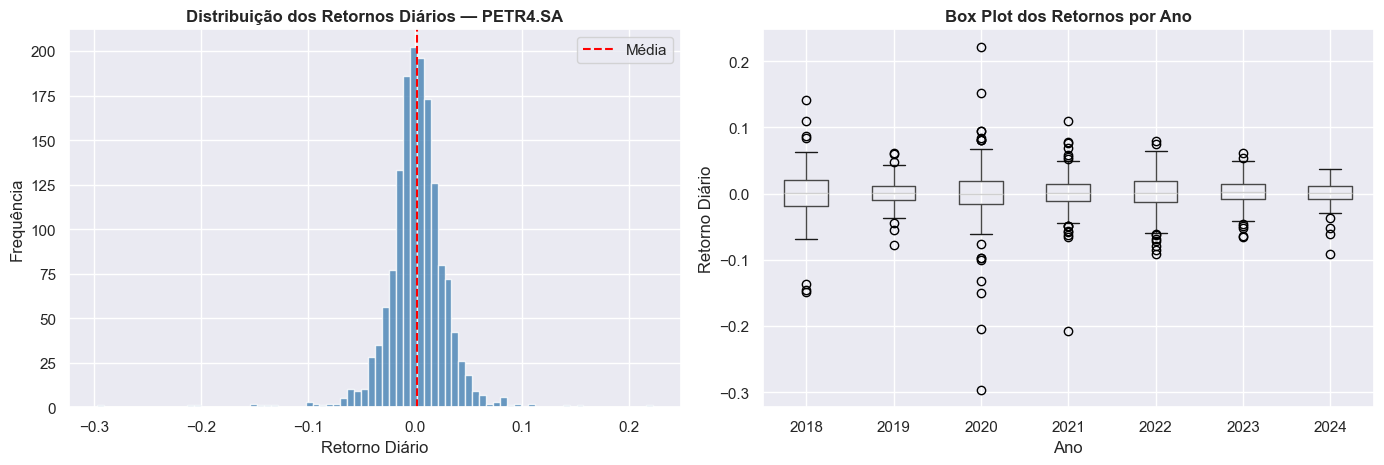

In [6]:
# ── Distribuição dos retornos diários ─────────────────────────────────────────
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Histograma
axes[0].hist(df['Daily_Return'].dropna(), bins=80, color='steelblue', edgecolor='white', alpha=0.8)
axes[0].axvline(df['Daily_Return'].mean(), color='red', linestyle='--', linewidth=1.5, label='Média')
axes[0].set_title('Distribuição dos Retornos Diários — PETR4.SA', fontweight='bold')
axes[0].set_xlabel('Retorno Diário')
axes[0].set_ylabel('Frequência')
axes[0].legend()

# Box plot por ano
df_ret = df[['Daily_Return']].copy()
df_ret['Ano'] = df_ret.index.year
df_ret.boxplot(column='Daily_Return', by='Ano', ax=axes[1], grid=True)
axes[1].set_title('Box Plot dos Retornos por Ano', fontweight='bold')
axes[1].set_xlabel('Ano')
axes[1].set_ylabel('Retorno Diário')
plt.suptitle('')

plt.tight_layout()
plt.show()

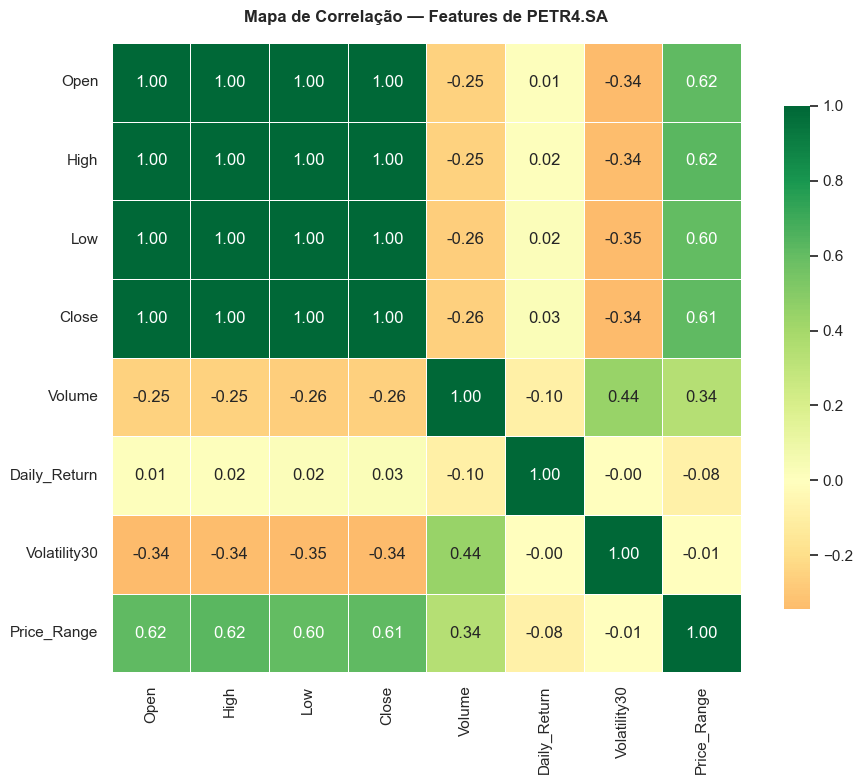


Correlação com o preço de fechamento (Close):
Close           1.000000
Low             0.999778
High            0.999732
Open            0.999448
Price_Range     0.612611
Daily_Return    0.028253
Volume         -0.256029
Volatility30   -0.341989


In [7]:
# ── Correlação entre variáveis ────────────────────────────────────────────────
cols_corr = ['Open', 'High', 'Low', 'Close', 'Volume', 'Daily_Return', 'Volatility30', 'Price_Range']
corr_matrix = df[cols_corr].corr()

fig, ax = plt.subplots(figsize=(10, 8))
mask = np.triu(np.ones_like(corr_matrix, dtype=bool), k=1)
sns.heatmap(
    corr_matrix,
    annot=True, fmt='.2f', cmap='RdYlGn',
    center=0, square=True, linewidths=0.5,
    ax=ax, cbar_kws={'shrink': 0.8}
)
ax.set_title('Mapa de Correlação — Features de PETR4.SA', fontweight='bold', pad=15)
plt.tight_layout()
plt.show()

print('\nCorrelação com o preço de fechamento (Close):')
print(corr_matrix['Close'].sort_values(ascending=False).to_string())

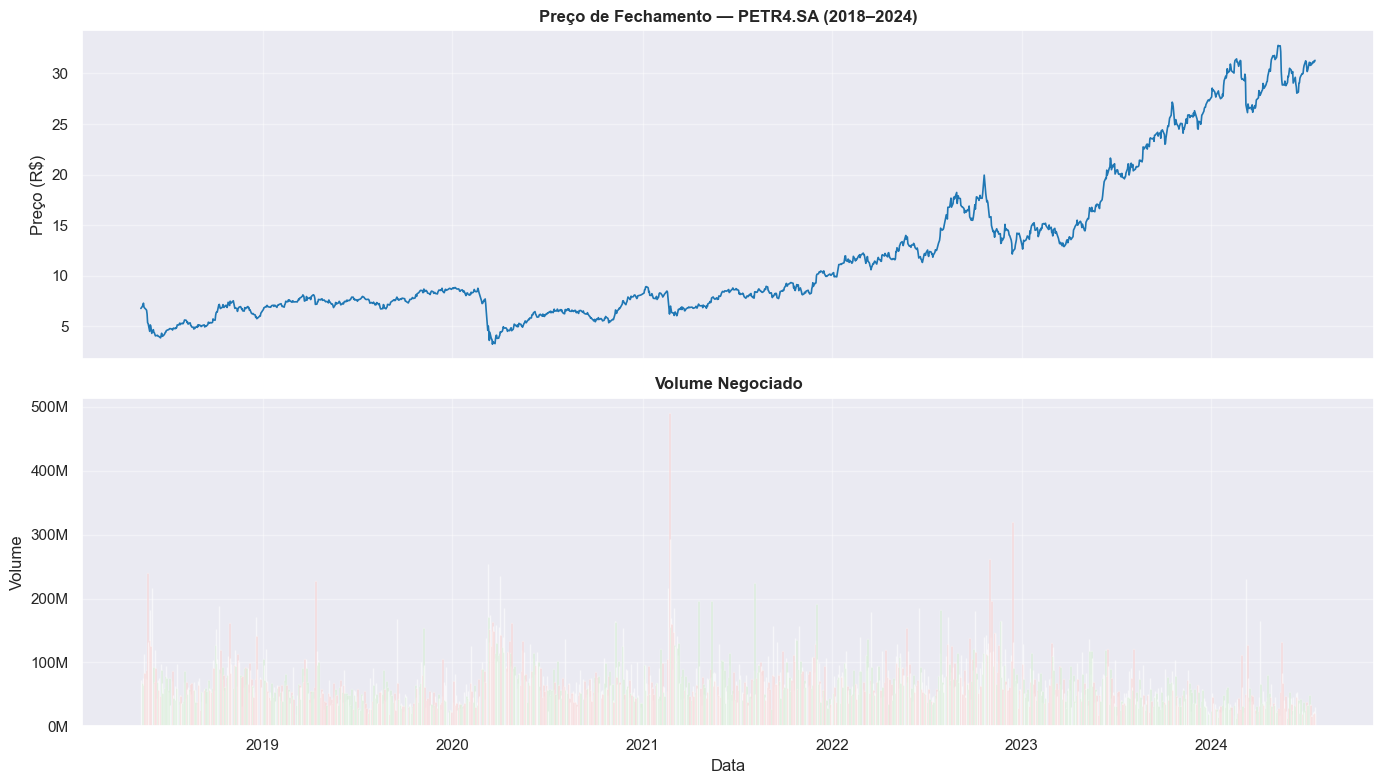

In [8]:
# ── Volume negociado ao longo do tempo ────────────────────────────────────────
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(14, 8), sharex=True)

ax1.plot(df.index, df['Close'], color='#1f77b4', linewidth=1.2)
ax1.set_title('Preço de Fechamento — PETR4.SA (2018–2024)', fontweight='bold')
ax1.set_ylabel('Preço (R$)')
ax1.grid(True, alpha=0.4)

colors = ['#d62728' if r < 0 else '#2ca02c' for r in df['Daily_Return']]
ax2.bar(df.index, df['Volume'], color=colors, alpha=0.6, width=1)
ax2.set_title('Volume Negociado', fontweight='bold')
ax2.set_ylabel('Volume')
ax2.set_xlabel('Data')
ax2.grid(True, alpha=0.4)
ax2.yaxis.set_major_formatter(plt.FuncFormatter(lambda x, _: f'{x/1e6:.0f}M'))

plt.tight_layout()
plt.show()

---
## 4. Visualizações <a id='4-visualizacoes'></a>

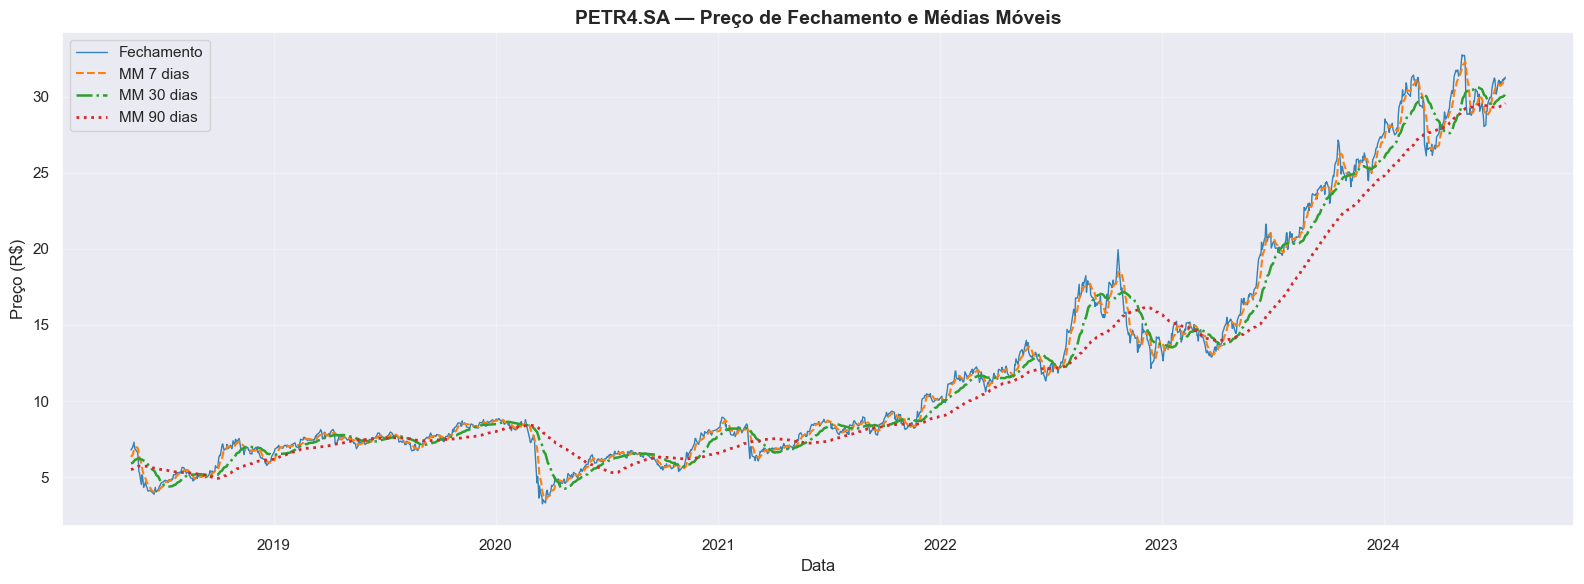

In [9]:
# ── Série temporal com médias móveis ──────────────────────────────────────────
fig, ax = plt.subplots(figsize=(16, 6))

ax.plot(df.index, df['Close'], color='#1f77b4', linewidth=1, alpha=0.9, label='Fechamento')
ax.plot(df.index, df['MA7'],   color='#ff7f0e', linewidth=1.5, linestyle='--', label='MM 7 dias')
ax.plot(df.index, df['MA30'],  color='#2ca02c', linewidth=1.8, linestyle='-.',  label='MM 30 dias')
ax.plot(df.index, df['MA90'],  color='#d62728', linewidth=2,   linestyle=':',   label='MM 90 dias')

ax.set_title('PETR4.SA — Preço de Fechamento e Médias Móveis', fontweight='bold', fontsize=14)
ax.set_xlabel('Data')
ax.set_ylabel('Preço (R$)')
ax.legend(loc='upper left')
ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y'))
ax.xaxis.set_major_locator(mdates.YearLocator())
ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

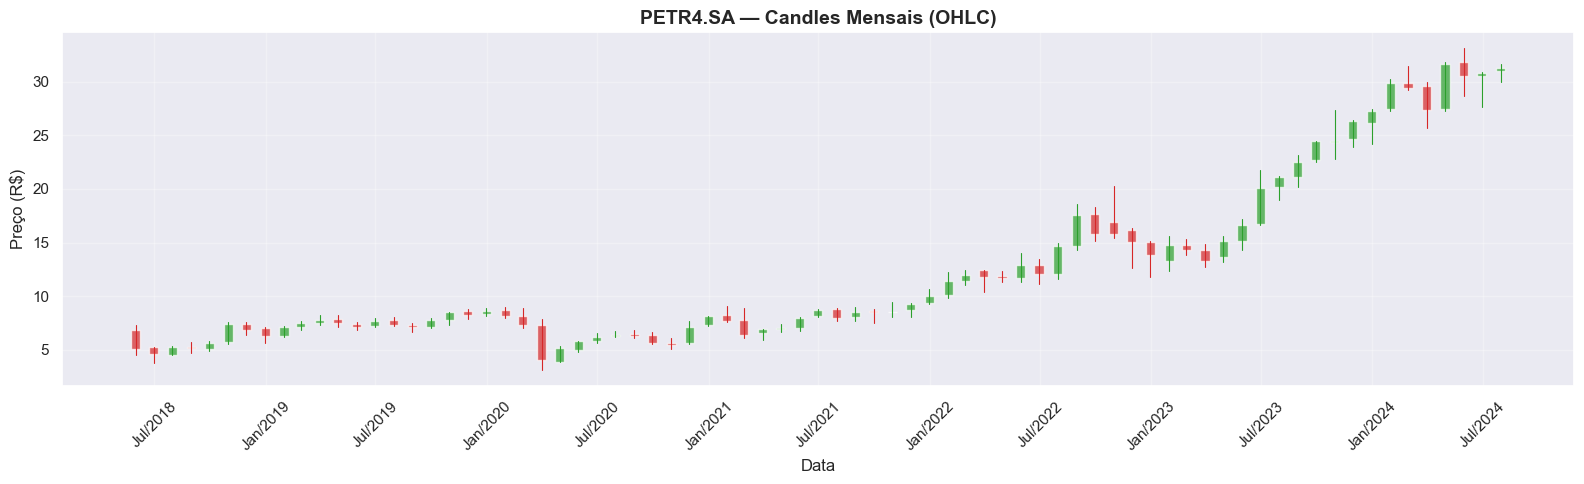

In [10]:
# ── Candlestick simplificado (OHLC mensal) ────────────────────────────────────
df_monthly = df[['Open', 'High', 'Low', 'Close', 'Volume']].resample('ME').agg({
    'Open'  : 'first',
    'High'  : 'max',
    'Low'   : 'min',
    'Close' : 'last',
    'Volume': 'sum'
})

fig, ax = plt.subplots(figsize=(16, 5))

for i, (date, row) in enumerate(df_monthly.iterrows()):
    color = '#2ca02c' if row['Close'] >= row['Open'] else '#d62728'
    ax.plot([date, date], [row['Low'], row['High']], color=color, linewidth=0.8)
    ax.bar(date, row['Close'] - row['Open'], bottom=row['Open'],
           color=color, alpha=0.7, width=15)

ax.set_title('PETR4.SA — Candles Mensais (OHLC)', fontweight='bold', fontsize=14)
ax.set_xlabel('Data')
ax.set_ylabel('Preço (R$)')
ax.xaxis.set_major_formatter(mdates.DateFormatter('%b/%Y'))
ax.xaxis.set_major_locator(mdates.MonthLocator(bymonth=[1, 7]))
plt.xticks(rotation=45)
ax.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

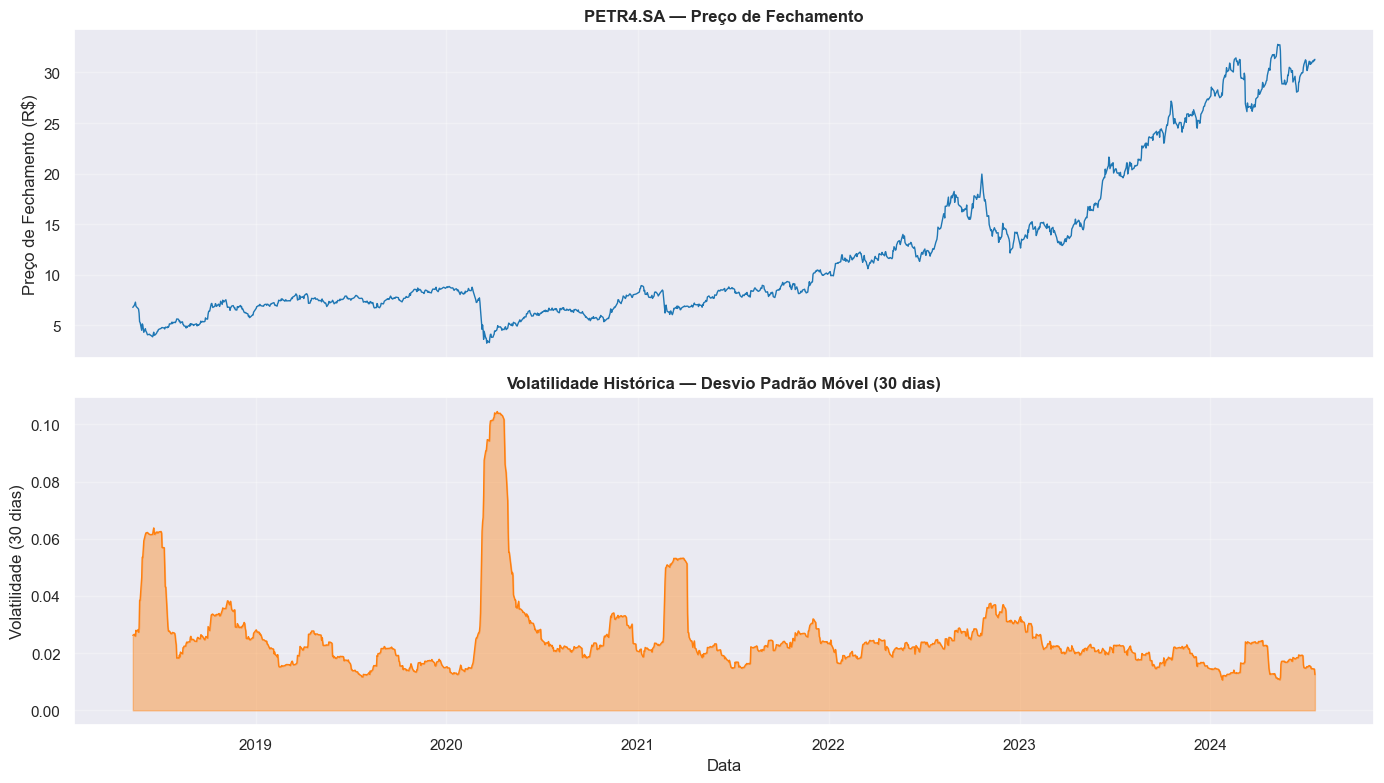

In [11]:
# ── Volatilidade histórica (30 dias) ──────────────────────────────────────────
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(14, 8), sharex=True)

ax1.plot(df.index, df['Close'], color='#1f77b4', linewidth=1)
ax1.set_ylabel('Preço de Fechamento (R$)')
ax1.set_title('PETR4.SA — Preço de Fechamento', fontweight='bold')
ax1.grid(True, alpha=0.3)

ax2.fill_between(df.index, df['Volatility30'], alpha=0.4, color='#ff7f0e')
ax2.plot(df.index, df['Volatility30'], color='#ff7f0e', linewidth=1)
ax2.set_ylabel('Volatilidade (30 dias)')
ax2.set_xlabel('Data')
ax2.set_title('Volatilidade Histórica — Desvio Padrão Móvel (30 dias)', fontweight='bold')
ax2.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

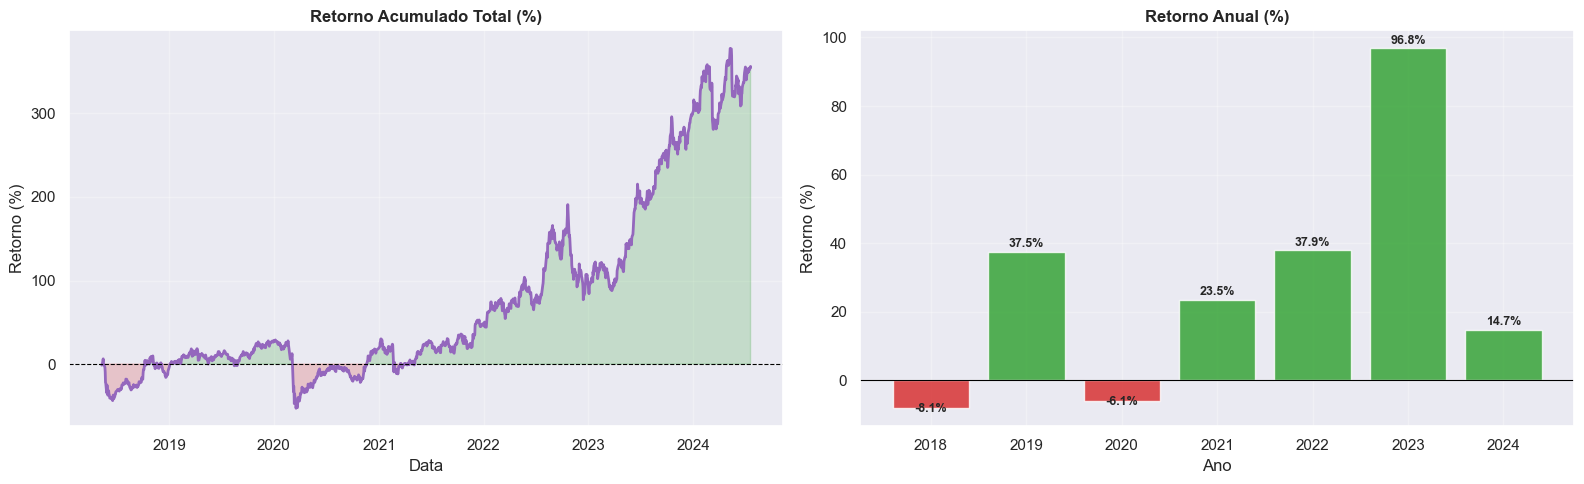

In [12]:
# ── Retorno anual acumulado ────────────────────────────────────────────────────
df['Cumulative_Return'] = (1 + df['Daily_Return']).cumprod() - 1

annual_returns = df['Daily_Return'].resample('YE').apply(lambda x: (1 + x).prod() - 1) * 100

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 5))

# Retorno acumulado
ax1.plot(df.index, df['Cumulative_Return'] * 100, color='#9467bd', linewidth=2)
ax1.axhline(0, color='black', linestyle='--', linewidth=0.8)
ax1.fill_between(df.index, df['Cumulative_Return'] * 100, 0,
                 where=(df['Cumulative_Return'] >= 0), alpha=0.2, color='#2ca02c')
ax1.fill_between(df.index, df['Cumulative_Return'] * 100, 0,
                 where=(df['Cumulative_Return'] < 0),  alpha=0.2, color='#d62728')
ax1.set_title('Retorno Acumulado Total (%)', fontweight='bold')
ax1.set_xlabel('Data')
ax1.set_ylabel('Retorno (%)')
ax1.grid(True, alpha=0.3)

# Retorno anual
colors_bar = ['#2ca02c' if v >= 0 else '#d62728' for v in annual_returns]
ax2.bar(annual_returns.index.year, annual_returns.values, color=colors_bar, alpha=0.8, edgecolor='white')
ax2.axhline(0, color='black', linewidth=0.8)
ax2.set_title('Retorno Anual (%)', fontweight='bold')
ax2.set_xlabel('Ano')
ax2.set_ylabel('Retorno (%)')
ax2.grid(True, alpha=0.3)

for bar, val in zip(ax2.patches, annual_returns.values):
    ax2.text(bar.get_x() + bar.get_width()/2, bar.get_height() + (0.5 if val >= 0 else -2),
             f'{val:.1f}%', ha='center', va='bottom', fontsize=9, fontweight='bold')

plt.tight_layout()
plt.show()

---
## 5. Análise de Séries Temporais <a id='5-series-temporais'></a>

In [13]:
# ── 5.1 Teste de Estacionariedade — Augmented Dickey-Fuller ───────────────────
def adf_test(series, name='Série'):
    result = adfuller(series.dropna(), autolag='AIC')
    print(f'--- Teste ADF: {name} ---')
    print(f'  Estatística ADF : {result[0]:.6f}')
    print(f'  p-value         : {result[1]:.6f}')
    print(f'  Lags utilizados : {result[2]}')
    print(f'  N. observações  : {result[3]}')
    print(f'  Valores críticos:')
    for key, val in result[4].items():
        print(f'    {key}: {val:.6f}')
    if result[1] < 0.05:
        print('  >>> Conclusão: Série ESTACIONÁRIA (rejeitamos H0)\n')
    else:
        print('  >>> Conclusão: Série NÃO ESTACIONÁRIA (não rejeitamos H0)\n')

# Testar preço original
adf_test(df['Close'], 'Preço de Fechamento (Close)')

# Testar série diferenciada
close_diff = df['Close'].diff().dropna()
adf_test(close_diff, 'Diferença de 1ª Ordem (Close)')

--- Teste ADF: Preço de Fechamento (Close) ---
  Estatística ADF : 0.685198
  p-value         : 0.989538
  Lags utilizados : 9
  N. observações  : 1527
  Valores críticos:
    1%: -3.434640
    5%: -2.863435
    10%: -2.567779
  >>> Conclusão: Série NÃO ESTACIONÁRIA (não rejeitamos H0)

--- Teste ADF: Diferença de 1ª Ordem (Close) ---
  Estatística ADF : -12.523851
  p-value         : 0.000000
  Lags utilizados : 8
  N. observações  : 1527
  Valores críticos:
    1%: -3.434640
    5%: -2.863435
    10%: -2.567779
  >>> Conclusão: Série ESTACIONÁRIA (rejeitamos H0)



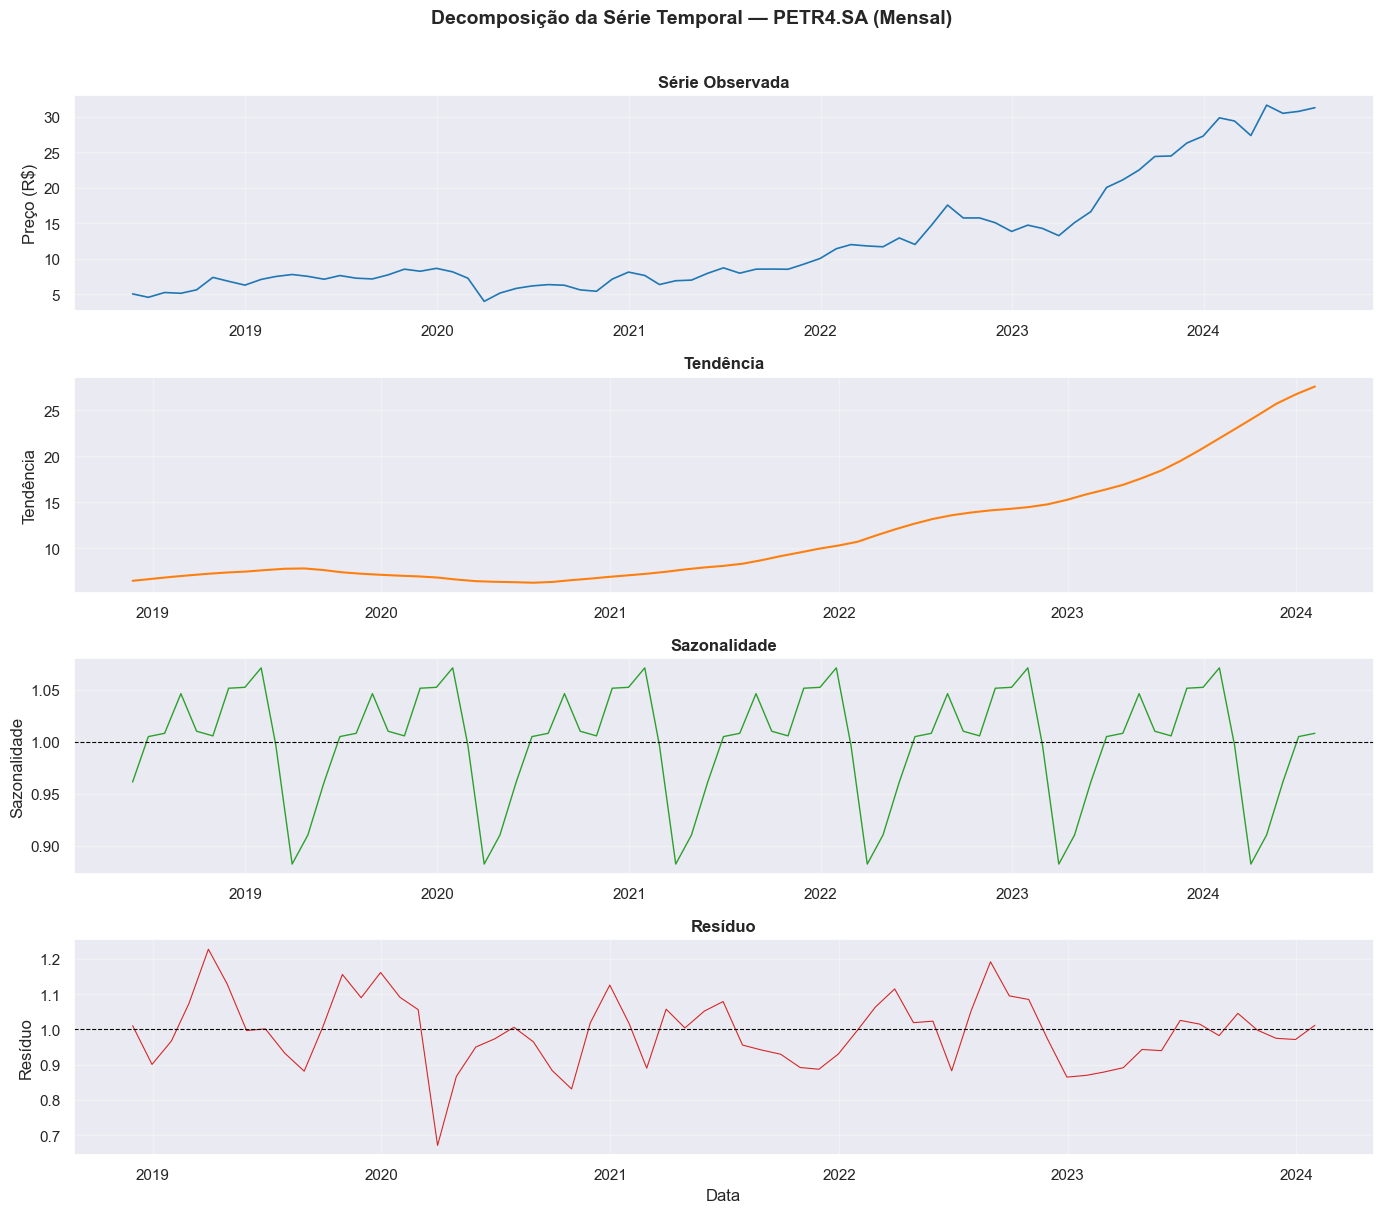

In [14]:
# ── 5.2 Decomposição da Série Temporal ────────────────────────────────────────
# Usar dados mensais para decomposição mais clara
close_monthly = df['Close'].resample('ME').last()

decomp = seasonal_decompose(close_monthly, model='multiplicative', period=12)

fig, axes = plt.subplots(4, 1, figsize=(14, 12))

axes[0].plot(decomp.observed, color='#1f77b4', linewidth=1.2)
axes[0].set_title('Série Observada', fontweight='bold')
axes[0].set_ylabel('Preço (R$)')
axes[0].grid(True, alpha=0.3)

axes[1].plot(decomp.trend, color='#ff7f0e', linewidth=1.5)
axes[1].set_title('Tendência', fontweight='bold')
axes[1].set_ylabel('Tendência')
axes[1].grid(True, alpha=0.3)

axes[2].plot(decomp.seasonal, color='#2ca02c', linewidth=1)
axes[2].axhline(1, color='black', linestyle='--', linewidth=0.8)
axes[2].set_title('Sazonalidade', fontweight='bold')
axes[2].set_ylabel('Sazonalidade')
axes[2].grid(True, alpha=0.3)

axes[3].plot(decomp.resid, color='#d62728', linewidth=0.8)
axes[3].axhline(1, color='black', linestyle='--', linewidth=0.8)
axes[3].set_title('Resíduo', fontweight='bold')
axes[3].set_ylabel('Resíduo')
axes[3].set_xlabel('Data')
axes[3].grid(True, alpha=0.3)

plt.suptitle('Decomposição da Série Temporal — PETR4.SA (Mensal)', fontweight='bold', fontsize=14, y=1.01)
plt.tight_layout()
plt.show()

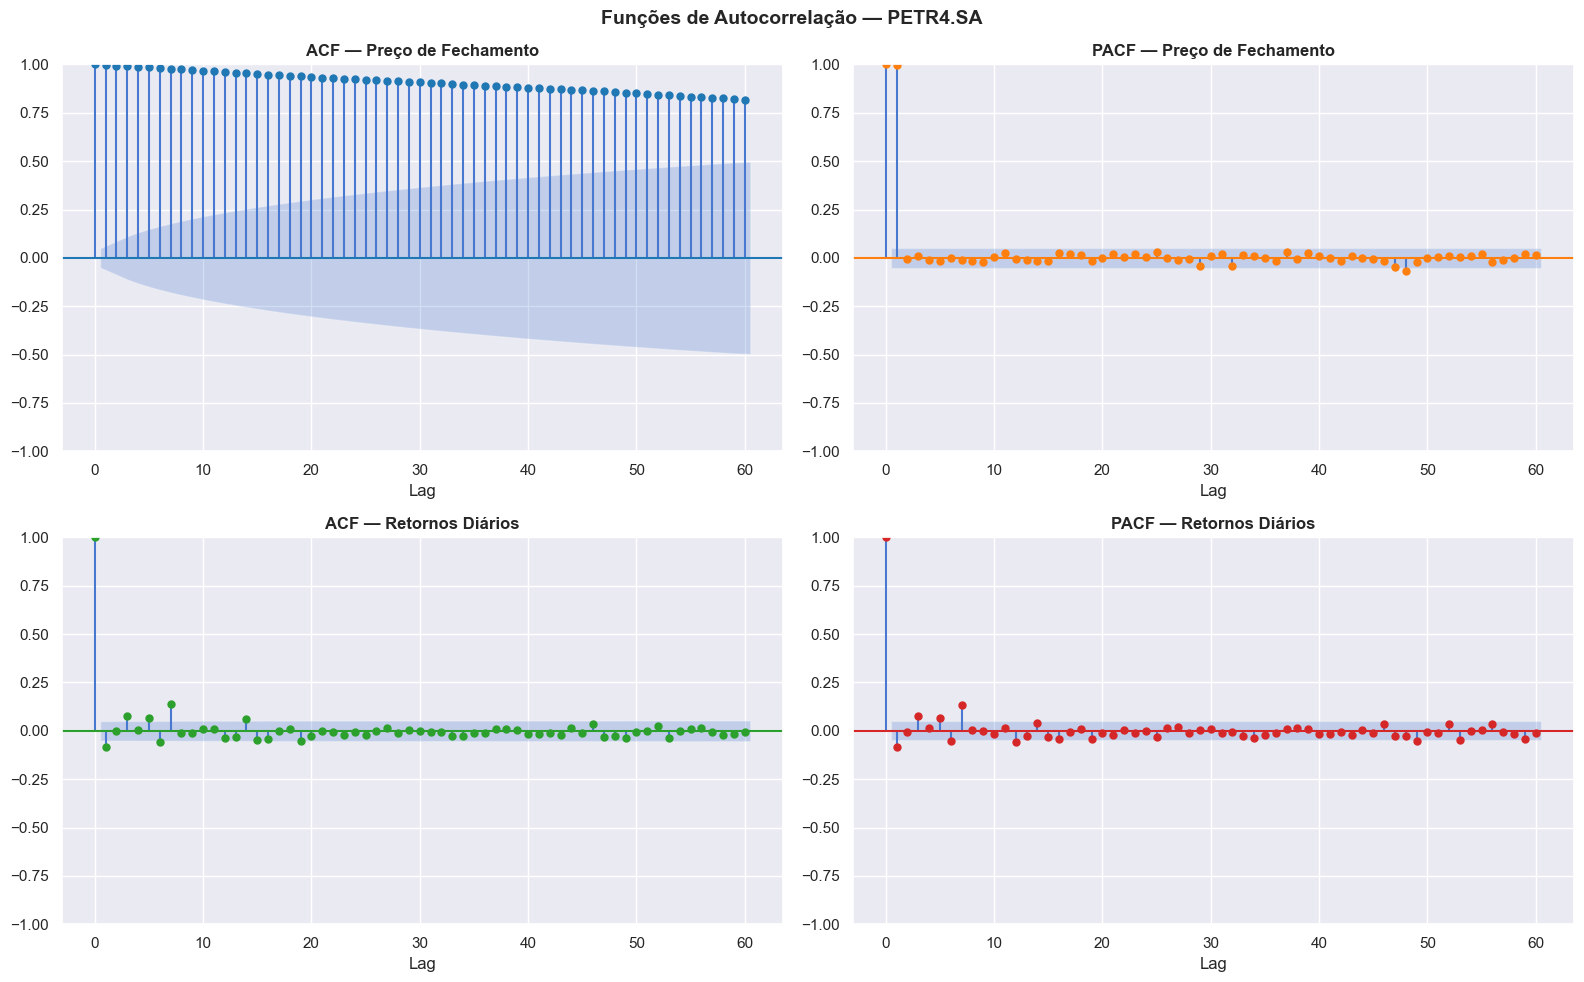


Interpretação:
  • ACF do preço: autocorrelação elevada e decaimento lento → série não estacionária (tendência)
  • PACF do preço: apenas lag-1 significativo → processo AR(1) como aproximação
  • ACF dos retornos: autocorrelações próximas de zero → retornos pouco autocorrelacionados (coerente com
    Hipótese dos Mercados Eficientes fraca)
  • Isso justifica usar o preço bruto normalizado como input do LSTM, capturando padrões sequenciais
    que não são lineares.



In [15]:
# ── 5.3 Autocorrelação (ACF) e Autocorrelação Parcial (PACF) ──────────────────
fig, axes = plt.subplots(2, 2, figsize=(16, 10))

# ACF — Preço
plot_acf(df['Close'], lags=60, ax=axes[0, 0], color='#1f77b4', alpha=0.05)
axes[0, 0].set_title('ACF — Preço de Fechamento', fontweight='bold')
axes[0, 0].set_xlabel('Lag')

# PACF — Preço
plot_pacf(df['Close'], lags=60, ax=axes[0, 1], method='ywm', color='#ff7f0e', alpha=0.05)
axes[0, 1].set_title('PACF — Preço de Fechamento', fontweight='bold')
axes[0, 1].set_xlabel('Lag')

# ACF — Retornos diários (série mais estacionária)
plot_acf(df['Daily_Return'], lags=60, ax=axes[1, 0], color='#2ca02c', alpha=0.05)
axes[1, 0].set_title('ACF — Retornos Diários', fontweight='bold')
axes[1, 0].set_xlabel('Lag')

# PACF — Retornos diários
plot_pacf(df['Daily_Return'], lags=60, ax=axes[1, 1], method='ywm', color='#d62728', alpha=0.05)
axes[1, 1].set_title('PACF — Retornos Diários', fontweight='bold')
axes[1, 1].set_xlabel('Lag')

plt.suptitle('Funções de Autocorrelação — PETR4.SA', fontweight='bold', fontsize=14)
plt.tight_layout()
plt.show()

print('''
Interpretação:
  • ACF do preço: autocorrelação elevada e decaimento lento → série não estacionária (tendência)
  • PACF do preço: apenas lag-1 significativo → processo AR(1) como aproximação
  • ACF dos retornos: autocorrelações próximas de zero → retornos pouco autocorrelacionados (coerente com
    Hipótese dos Mercados Eficientes fraca)
  • Isso justifica usar o preço bruto normalizado como input do LSTM, capturando padrões sequenciais
    que não são lineares.
''')

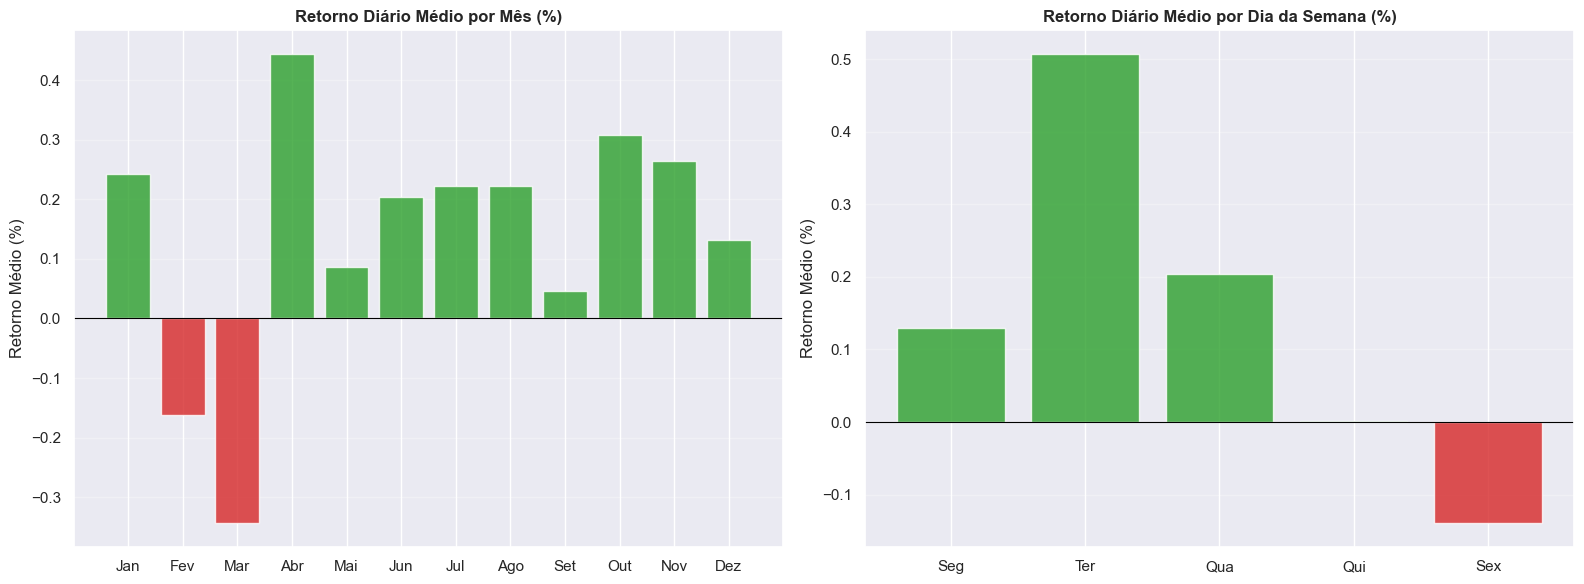

In [16]:
# ── 5.4 Análise de sazonalidade anual e mensal ────────────────────────────────
df_seasonal = df[['Close', 'Daily_Return']].copy()
df_seasonal['Mes']   = df_seasonal.index.month
df_seasonal['Ano']   = df_seasonal.index.year
df_seasonal['DiaSem'] = df_seasonal.index.dayofweek  # 0=seg … 4=sex

fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Retorno médio por mês
monthly_ret = df_seasonal.groupby('Mes')['Daily_Return'].mean() * 100
month_names = ['Jan','Fev','Mar','Abr','Mai','Jun','Jul','Ago','Set','Out','Nov','Dez']
colors_m = ['#2ca02c' if v >= 0 else '#d62728' for v in monthly_ret]
axes[0].bar(range(1, 13), monthly_ret.values, color=colors_m, alpha=0.8, edgecolor='white')
axes[0].set_xticks(range(1, 13))
axes[0].set_xticklabels(month_names)
axes[0].axhline(0, color='black', linewidth=0.8)
axes[0].set_title('Retorno Diário Médio por Mês (%)', fontweight='bold')
axes[0].set_ylabel('Retorno Médio (%)')
axes[0].grid(True, alpha=0.3, axis='y')

# Retorno médio por dia da semana
day_ret = df_seasonal.groupby('DiaSem')['Daily_Return'].mean() * 100
day_names = ['Seg', 'Ter', 'Qua', 'Qui', 'Sex']
colors_d = ['#2ca02c' if v >= 0 else '#d62728' for v in day_ret]
axes[1].bar(range(5), day_ret.values, color=colors_d, alpha=0.8, edgecolor='white')
axes[1].set_xticks(range(5))
axes[1].set_xticklabels(day_names)
axes[1].axhline(0, color='black', linewidth=0.8)
axes[1].set_title('Retorno Diário Médio por Dia da Semana (%)', fontweight='bold')
axes[1].set_ylabel('Retorno Médio (%)')
axes[1].grid(True, alpha=0.3, axis='y')

plt.tight_layout()
plt.show()

---
## 6. Desenvolvimento do Modelo LSTM <a id='6-lstm'></a>

In [17]:
# ── 6.1 Preparação dos Dados para o LSTM ────────────────────────────────────
#
# Abordagem: normalização POR JANELA (per-window normalization)
#   • Cada sequência de LOOK_BACK dias é dividida pelo seu PRIMEIRO elemento
#   • Resultado: janela começa em 1.0 e mostra variações relativas
#   • Resolve o distribution shift sem usar log-returns:
#     uma janela onde o preço vai de R$5 a R$6 (+20%) e outra onde vai
#     de R$25 a R$30 (+20%) têm exatamente a mesma representação numérica
#   • Sem scaler global → sem data leakage, sem saturação fora do range

LOOK_BACK = 60   # 60 dias úteis ~ 3 meses de pregão

close_prices = df['Close'].values.reshape(-1, 1)
n_total      = len(close_prices)

# Split por índice ANTES de qualquer transformação
train_end_idx = int(n_total * 0.70)
val_end_idx   = int(n_total * 0.85)

print(f'Total de amostras : {n_total}')
print(f'Treino            : {train_end_idx}  ({train_end_idx/n_total*100:.1f}%)')
print(f'Validação         : {val_end_idx - train_end_idx}  ({(val_end_idx-train_end_idx)/n_total*100:.1f}%)')
print(f'Teste             : {n_total - val_end_idx}  ({(n_total-val_end_idx)/n_total*100:.1f}%)')
print(f'Look-back         : {LOOK_BACK} dias')


Total de amostras : 1537
Treino            : 1075  (69.9%)
Validação         : 231  (15.0%)
Teste             : 231  (15.0%)
Look-back         : 60 dias


In [18]:
# ── 6.2 Criação das Sequências com Normalização por Janela ───────────────────

def create_sequences_normalized(data, look_back):
    """
    Para cada posição i cria:
      X[i] = data[i-look_back : i]   / data[i-look_back]   (janela normalizada)
      y[i] = data[i]                 / data[i-look_back]   (target normalizado)
      ref[i] = data[i-look_back]                           (preço de referência)
    Reconstrução: preço_real = y_pred * ref
    """
    X, y, refs = [], [], []
    for i in range(look_back, len(data)):
        ref = data[i - look_back, 0]      # primeiro elemento da janela
        X.append(data[i - look_back : i, 0] / ref)   # shape: [look_back]
        y.append(data[i, 0] / ref)                   # escalar
        refs.append(ref)
    return np.array(X), np.array(y), np.array(refs)

# ── Treino ───────────────────────────────────────────────────────────────────
X_train_n, y_train_n, refs_train = create_sequences_normalized(
    close_prices[:train_end_idx], LOOK_BACK
)

# ── Validação (buffer de LOOK_BACK antes do split) ────────────────────────────
X_val_n, y_val_n, refs_val = create_sequences_normalized(
    close_prices[train_end_idx - LOOK_BACK : val_end_idx], LOOK_BACK
)

# ── Teste (buffer de LOOK_BACK antes do split) ────────────────────────────────
X_test_n, y_test_n, refs_test = create_sequences_normalized(
    close_prices[val_end_idx - LOOK_BACK :], LOOK_BACK
)

# Reshape para LSTM: [amostras, timesteps, 1]
X_train = X_train_n.reshape(-1, LOOK_BACK, 1)
X_val   = X_val_n.reshape(-1, LOOK_BACK, 1)
X_test  = X_test_n.reshape(-1, LOOK_BACK, 1)
y_train, y_val, y_test = y_train_n, y_val_n, y_test_n

print(f'X_train : {X_train.shape} | y_train : {y_train.shape}')
print(f'X_val   : {X_val.shape}   | y_val   : {y_val.shape}')
print(f'X_test  : {X_test.shape}  | y_test  : {y_test.shape}')
print(f'\ny normalizado — treino: min={y_train.min():.4f} | max={y_train.max():.4f} | std={y_train.std():.4f}')
print(f'y normalizado — teste : min={y_test.min():.4f}  | max={y_test.max():.4f}  | std={y_test.std():.4f}')
print('(valores próximos de 1.0 — sem distribution shift entre splits)')

# Índices de datas para visualizações
dates_train = df.index[LOOK_BACK : train_end_idx]
dates_val   = df.index[train_end_idx : val_end_idx]
dates_test  = df.index[val_end_idx :]


X_train : (1015, 60, 1) | y_train : (1015,)
X_val   : (231, 60, 1)   | y_val   : (231,)
X_test  : (231, 60, 1)  | y_test  : (231,)

y normalizado — treino: min=0.3835 | max=1.8928 | std=0.2151
y normalizado — teste : min=0.9263  | max=1.3631  | std=0.0921
(valores próximos de 1.0 — sem distribution shift entre splits)


In [19]:
# ── 6.3 Arquitetura LSTM ──────────────────────────────────────────────────────
#
# Com a normalização por janela os valores de entrada estão em ~[0.5, 1.5]
# e o target em ~[0.95, 1.05] para a maioria dos dias.
# Isso facilita muito o aprendizado — arquitetura mais limpa é suficiente.


#def build_lstm_model(look_back,
#                     units_1=128, units_2=64,
#                     dropout_rate=0.2, rec_dropout=0.1,
#                     learning_rate=1e-3, l2_reg=1e-4):


def build_lstm_model(look_back,
                     units_1=128, units_2=64,
                     dropout_rate=0.25, rec_dropout=0.1,
                     learning_rate=1e-3, l2_reg=5e-4):
    """LSTM 2 camadas com regularização — entrada já normalizada por janela."""
    model = Sequential([
        LSTM(units_1, return_sequences=True,
             recurrent_dropout=rec_dropout,
             kernel_regularizer=l2(l2_reg),
             input_shape=(look_back, 1)),
        Dropout(dropout_rate),

        LSTM(units_2, return_sequences=False,
             recurrent_dropout=rec_dropout,
             kernel_regularizer=l2(l2_reg)),
        BatchNormalization(),
        Dropout(dropout_rate),

        Dense(32, activation='relu', kernel_regularizer=l2(l2_reg)),
        Dense(1)   # saída: preço_amanhã / preço_ref (ratio, ~1.0)
    ])

    model.compile(
        optimizer=Adam(learning_rate=learning_rate, clipnorm=1.0),
        loss='huber',
        metrics=['mae']
    )
    return model

model = build_lstm_model(LOOK_BACK)
model.summary()
print(f'\nParâmetros treináveis: {model.count_params():,}')


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                     │ (None, 60, 128)        │        66,560 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 60, 128)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_1 (LSTM)                   │ (None, 64)             │        49,408 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 64)             │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 118,337 (462.25 KB)

 Trainable params: 118,209 (461.75 KB)

 Non-trainable params: 128 (512.00 B)


Parâmetros treináveis: 118,337


In [20]:
# ── 6.4 Treinamento do Modelo ─────────────────────────────────────────────────
os.makedirs('../models', exist_ok=True)

callbacks = [
    EarlyStopping(
        monitor='val_loss', patience=20,
        restore_best_weights=True, verbose=1
    ),
    ReduceLROnPlateau(
        monitor='val_loss', factor=0.5,
        patience=8, min_lr=1e-7, verbose=1
    ),
    ModelCheckpoint(
        filepath='../models/lstm_petr4_best.keras',
        monitor='val_loss', save_best_only=True, verbose=0
    )
]

EPOCHS     = 150
BATCH_SIZE = 32

history = model.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=EPOCHS,
    batch_size=BATCH_SIZE,
    callbacks=callbacks,
    verbose=1
)

print(f'\nMelhor epoch    : {np.argmin(history.history["val_loss"]) + 1}')
print(f'Melhor val_loss : {min(history.history["val_loss"]):.6f}')


Epoch 1/150
32/32 ━━━━━━━━━━━━━━━━━━━━ 5s 65ms/step - loss: 0.4986 - mae: 0.7942 - val_loss: 0.4343 - val_mae: 0.7963 - learning_rate: 0.0010
Epoch 2/150
32/32 ━━━━━━━━━━━━━━━━━━━━ 2s 55ms/step - loss: 0.2151 - mae: 0.4045 - val_loss: 0.3606 - val_mae: 0.7096 - learning_rate: 0.0010
Epoch 3/150
32/32 ━━━━━━━━━━━━━━━━━━━━ 2s 55ms/step - loss: 0.1541 - mae: 0.3009 - val_loss: 0.3226 - val_mae: 0.6624 - learning_rate: 0.0010
Epoch 4/150
32/32 ━━━━━━━━━━━━━━━━━━━━ 2s 57ms/step - loss: 0.1225 - mae: 0.2473 - val_loss: 0.2964 - val_mae: 0.6386 - learning_rate: 0.0010
Epoch 5/150
32/32 ━━━━━━━━━━━━━━━━━━━━ 2s 57ms/step - loss: 0.1089 - mae: 0.2316 - val_loss: 0.2415 - val_mae: 0.5561 - learning_rate: 0.0010
Epoch 6/150
32/32 ━━━━━━━━━━━━━━━━━━━━ 2s 58ms/step - loss: 0.0944 - mae: 0.2085 - val_loss: 0.1908 - val_mae: 0.4742 - learning_rate: 0.0010
Epoch 7/150
32/32 ━━━━━━━━━━━━━━━━━━━━ 2s 58ms/step - loss: 0.0784 - mae: 0.1703 - val_loss: 0.1666 - val_mae: 0.4280 - learning_rate: 0.0010
Epoch 

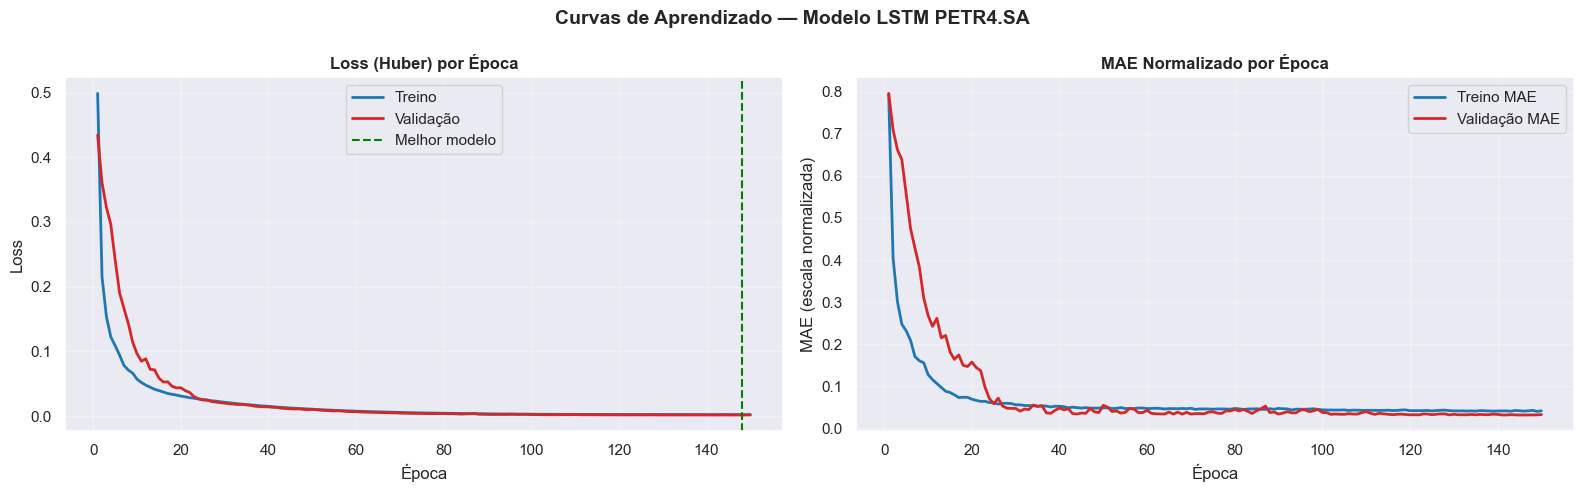

In [21]:
# ── 6.5 Curvas de aprendizado ─────────────────────────────────────────────────
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 5))

epochs_range = range(1, len(history.history['loss']) + 1)

ax1.plot(epochs_range, history.history['loss'],     color='#1f77b4', label='Treino', linewidth=2)
ax1.plot(epochs_range, history.history['val_loss'], color='#d62728', label='Validação', linewidth=2)
ax1.axvline(np.argmin(history.history['val_loss']) + 1,
            color='green', linestyle='--', linewidth=1.5, label='Melhor modelo')
ax1.set_title('Loss (Huber) por Época', fontweight='bold')
ax1.set_xlabel('Época')
ax1.set_ylabel('Loss')
ax1.legend()
ax1.grid(True, alpha=0.3)

ax2.plot(epochs_range, history.history['mae'],     color='#1f77b4', label='Treino MAE', linewidth=2)
ax2.plot(epochs_range, history.history['val_mae'], color='#d62728', label='Validação MAE', linewidth=2)
ax2.set_title('MAE Normalizado por Época', fontweight='bold')
ax2.set_xlabel('Época')
ax2.set_ylabel('MAE (escala normalizada)')
ax2.legend()
ax2.grid(True, alpha=0.3)

plt.suptitle('Curvas de Aprendizado — Modelo LSTM PETR4.SA', fontweight='bold', fontsize=14)
plt.tight_layout()
plt.show()

---
## 7. Otimização de Performance e Avaliação <a id='7-otimizacao'></a>

In [22]:
# ── 7.1 Métricas de Avaliação (preços denormalizados) ────────────────────────
#
# Denormalização: preço_real = y_norm * ref
# onde ref = primeiro elemento da janela de cada amostra

def evaluate_model(model, X, y_norm_true, refs, set_name='Conjunto'):
    """Avalia o modelo denormalizando previsões para R$ reais."""
    y_norm_pred = model.predict(X, verbose=0).flatten()

    # Denormalizar → preços reais
    y_true_prices = y_norm_true * refs
    y_pred_prices = y_norm_pred * refs

    mae  = mean_absolute_error(y_true_prices, y_pred_prices)
    rmse = np.sqrt(mean_squared_error(y_true_prices, y_pred_prices))
    mape = np.mean(np.abs((y_true_prices - y_pred_prices) / y_true_prices)) * 100
    r2   = 1 - (np.sum((y_true_prices - y_pred_prices)**2) /
                np.sum((y_true_prices - np.mean(y_true_prices))**2))

    print(f'=== Métricas — {set_name} ===')
    print(f'  MAE  : R$ {mae:.4f}')
    print(f'  RMSE : R$ {rmse:.4f}')
    print(f'  MAPE : {mape:.4f}%')
    print(f'  R²   : {r2:.4f}')
    print()

    return y_true_prices, y_pred_prices, {'MAE': mae, 'RMSE': rmse, 'MAPE': mape, 'R2': r2}

y_train_true, y_train_pred, metrics_train = evaluate_model(
    model, X_train, y_train, refs_train, 'Treino')
y_val_true,   y_val_pred,   metrics_val   = evaluate_model(
    model, X_val,   y_val,   refs_val,   'Validação')
y_test_true,  y_test_pred,  metrics_test  = evaluate_model(
    model, X_test,  y_test,  refs_test,  'Teste')

min_tr = min(len(dates_train), len(y_train_true))
min_vl = min(len(dates_val),   len(y_val_true))
min_te = min(len(dates_test),  len(y_test_true))


=== Métricas — Treino ===
  MAE  : R$ 0.2050
  RMSE : R$ 0.2906
  MAPE : 2.6512%
  R²   : 0.9868

=== Métricas — Validação ===
  MAE  : R$ 0.4626
  RMSE : R$ 0.5980
  MAPE : 2.9323%
  R²   : 0.9463

=== Métricas — Teste ===
  MAE  : R$ 0.5008
  RMSE : R$ 0.7087
  MAPE : 1.8315%
  R²   : 0.9360



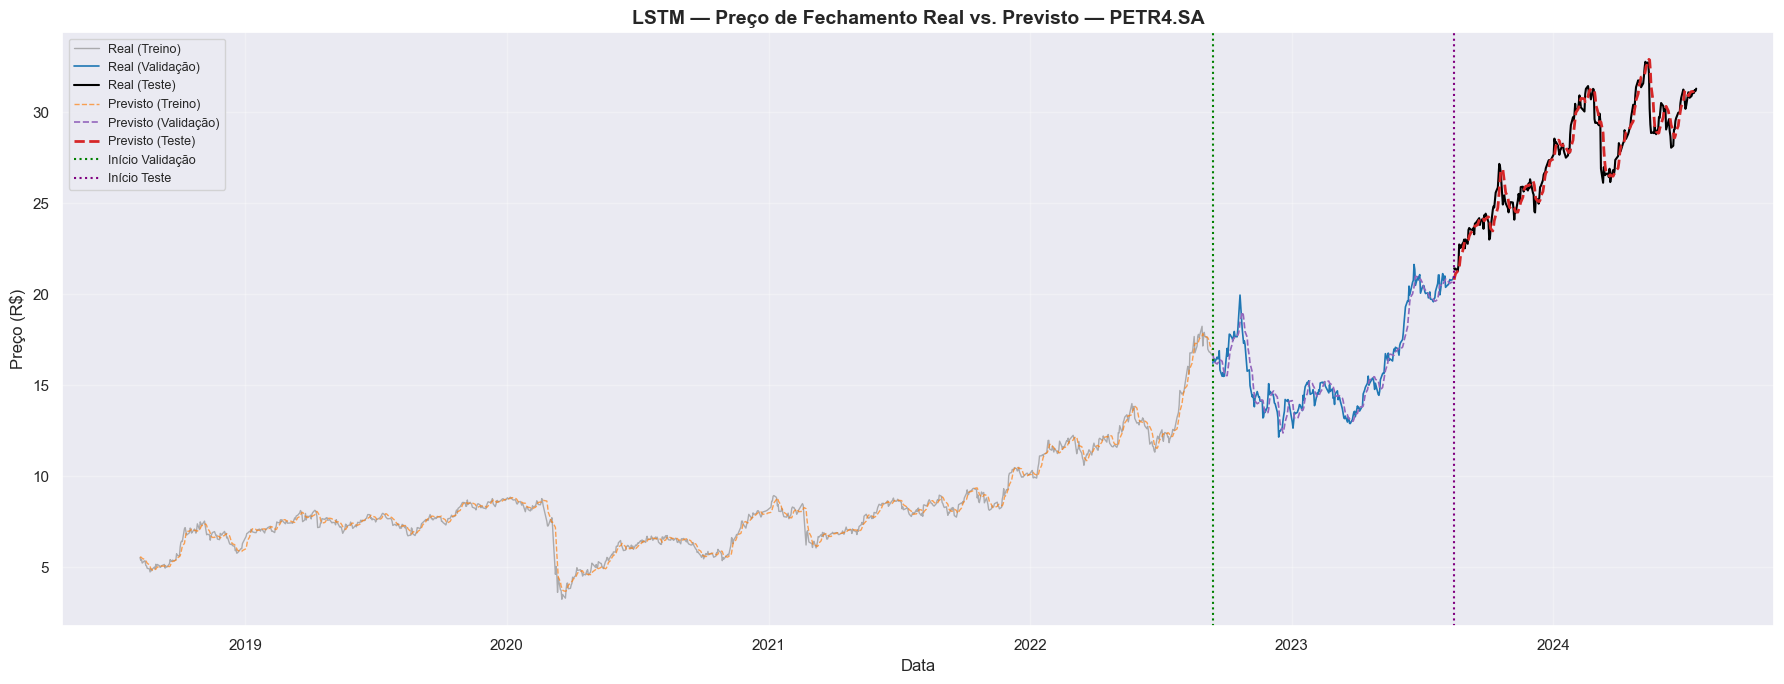

In [23]:
# ── 7.2 Visualização das previsões vs. real ───────────────────────────────────
# dates_train / dates_val / dates_test já foram definidos na célula 6.2

min_tr = min(len(dates_train), len(y_train_true))
min_vl = min(len(dates_val),   len(y_val_true))
min_te = min(len(dates_test),  len(y_test_true))

fig, ax = plt.subplots(figsize=(18, 7))

ax.plot(dates_train[:min_tr], y_train_true[:min_tr],
        color='gray', linewidth=1, alpha=0.6, label='Real (Treino)')
ax.plot(dates_val[:min_vl], y_val_true[:min_vl],
        color='#1f77b4', linewidth=1.2, label='Real (Validação)')
ax.plot(dates_test[:min_te], y_test_true[:min_te],
        color='black', linewidth=1.5, label='Real (Teste)')

ax.plot(dates_train[:min_tr], y_train_pred[:min_tr],
        color='#ff7f0e', linewidth=1, alpha=0.7, linestyle='--', label='Previsto (Treino)')
ax.plot(dates_val[:min_vl], y_val_pred[:min_vl],
        color='#9467bd', linewidth=1.2, linestyle='--', label='Previsto (Validação)')
ax.plot(dates_test[:min_te], y_test_pred[:min_te],
        color='#d62728', linewidth=2, linestyle='--', label='Previsto (Teste)')

ax.axvline(dates_val[0],  color='green',  linestyle=':', linewidth=1.5, label='Início Validação')
ax.axvline(dates_test[0], color='purple', linestyle=':', linewidth=1.5, label='Início Teste')

ax.set_title('LSTM — Preço de Fechamento Real vs. Previsto — PETR4.SA', fontweight='bold', fontsize=14)
ax.set_xlabel('Data')
ax.set_ylabel('Preço (R$)')
ax.legend(loc='upper left', fontsize=9)
ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()


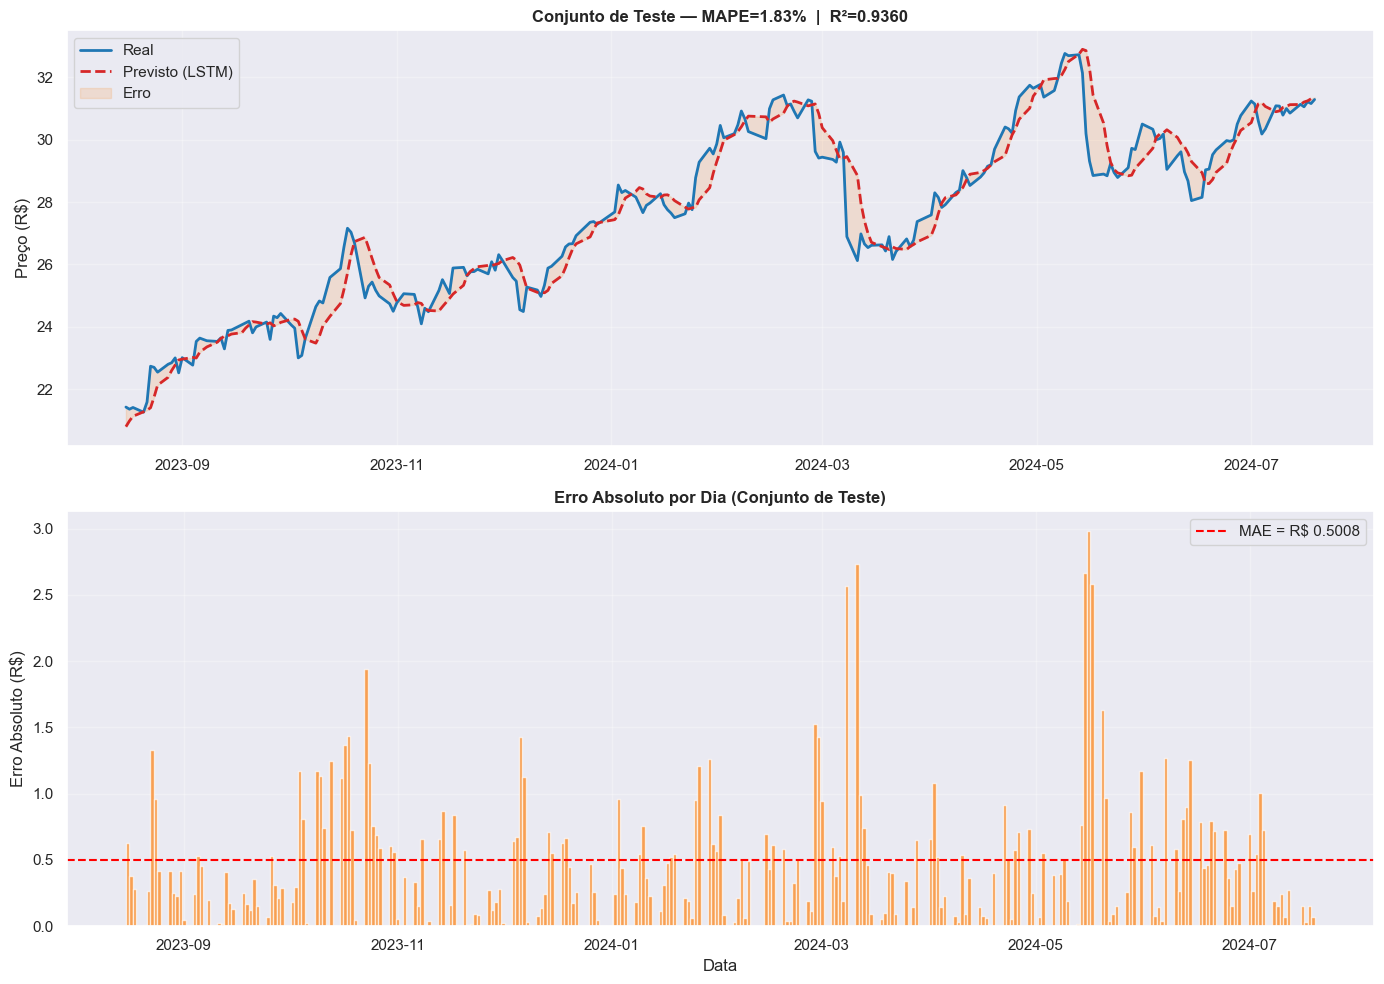

In [24]:
# ── 7.3 Zoom no conjunto de teste ─────────────────────────────────────────────
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(14, 10))

# Preço real vs previsto
ax1.plot(dates_test[:min_te], y_test_true[:min_te],
         color='#1f77b4', linewidth=2, label='Real')
ax1.plot(dates_test[:min_te], y_test_pred[:min_te],
         color='#d62728', linewidth=2, linestyle='--', label='Previsto (LSTM)')
ax1.fill_between(dates_test[:min_te], y_test_true[:min_te], y_test_pred[:min_te],
                 alpha=0.15, color='#ff7f0e', label='Erro')
ax1.set_title(f'Conjunto de Teste — MAPE={metrics_test["MAPE"]:.2f}%  |  R²={metrics_test["R2"]:.4f}',
              fontweight='bold')
ax1.set_ylabel('Preço (R$)')
ax1.legend()
ax1.grid(True, alpha=0.3)

# Erro absoluto por dia
abs_error = np.abs(y_test_true[:min_te] - y_test_pred[:min_te])
ax2.bar(dates_test[:min_te], abs_error, color='#ff7f0e', alpha=0.7, width=1)
ax2.axhline(abs_error.mean(), color='red', linestyle='--', linewidth=1.5,
            label=f'MAE = R$ {abs_error.mean():.4f}')
ax2.set_title('Erro Absoluto por Dia (Conjunto de Teste)', fontweight='bold')
ax2.set_xlabel('Data')
ax2.set_ylabel('Erro Absoluto (R$)')
ax2.legend()
ax2.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()


In [25]:
# ── 7.4 Tabela comparativa de métricas ────────────────────────────────────────
metrics_df = pd.DataFrame({
    'Conjunto'  : ['Treino',  'Validação', 'Teste'],
    'MAE (R$)'  : [metrics_train['MAE'],  metrics_val['MAE'],  metrics_test['MAE']],
    'RMSE (R$)' : [metrics_train['RMSE'], metrics_val['RMSE'], metrics_test['RMSE']],
    'MAPE (%)'  : [metrics_train['MAPE'], metrics_val['MAPE'], metrics_test['MAPE']],
    'R2'        : [metrics_train['R2'],   metrics_val['R2'],   metrics_test['R2']],
}).set_index('Conjunto')

print('=== Resumo de Métricas ===')
display(metrics_df.style.format({
    'MAE (R$)' : '{:.4f}',
    'RMSE (R$)': '{:.4f}',
    'MAPE (%)' : '{:.4f}',
    'R2'       : '{:.4f}',
}).background_gradient(cmap='RdYlGn', subset=['R2'])
 .background_gradient(cmap='RdYlGn_r', subset=['MAE (R$)', 'RMSE (R$)', 'MAPE (%)']))


=== Resumo de Métricas ===


,MAE (R$),RMSE (R$),MAPE (%),R2
Conjunto,,,,
Treino,0.2050,0.2906,2.6512,0.9868
Validação,0.4626,0.5980,2.9323,0.9463
Teste,0.5008,0.7087,1.8315,0.9360


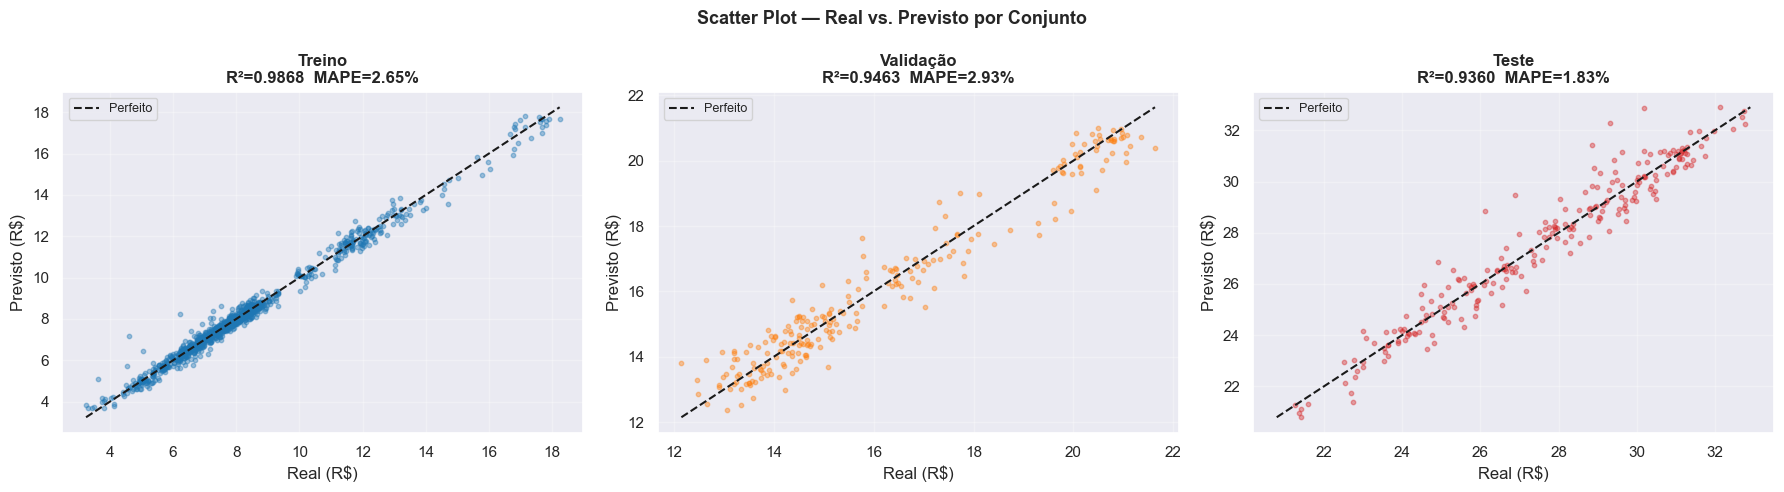

In [26]:
# ── 7.5 Scatter Plot: Real vs Previsto ────────────────────────────────────────
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

datasets = [
    (y_train_true, y_train_pred, metrics_train, 'Treino',    '#1f77b4'),
    (y_val_true,   y_val_pred,   metrics_val,   'Validação', '#ff7f0e'),
    (y_test_true,  y_test_pred,  metrics_test,  'Teste',     '#d62728'),
]

for ax, (true, pred, metrics, name, color) in zip(axes, datasets):
    ax.scatter(true, pred, alpha=0.4, color=color, s=10)
    mn, mx = min(true.min(), pred.min()), max(true.max(), pred.max())
    ax.plot([mn, mx], [mn, mx], 'k--', linewidth=1.5, label='Perfeito')
    ax.set_title(f'{name}\nR²={metrics["R2"]:.4f}  MAPE={metrics["MAPE"]:.2f}%', fontweight='bold')
    ax.set_xlabel('Real (R$)')
    ax.set_ylabel('Previsto (R$)')
    ax.legend(fontsize=9)
    ax.grid(True, alpha=0.3)

plt.suptitle('Scatter Plot — Real vs. Previsto por Conjunto', fontweight='bold', fontsize=13)
plt.tight_layout()
plt.show()

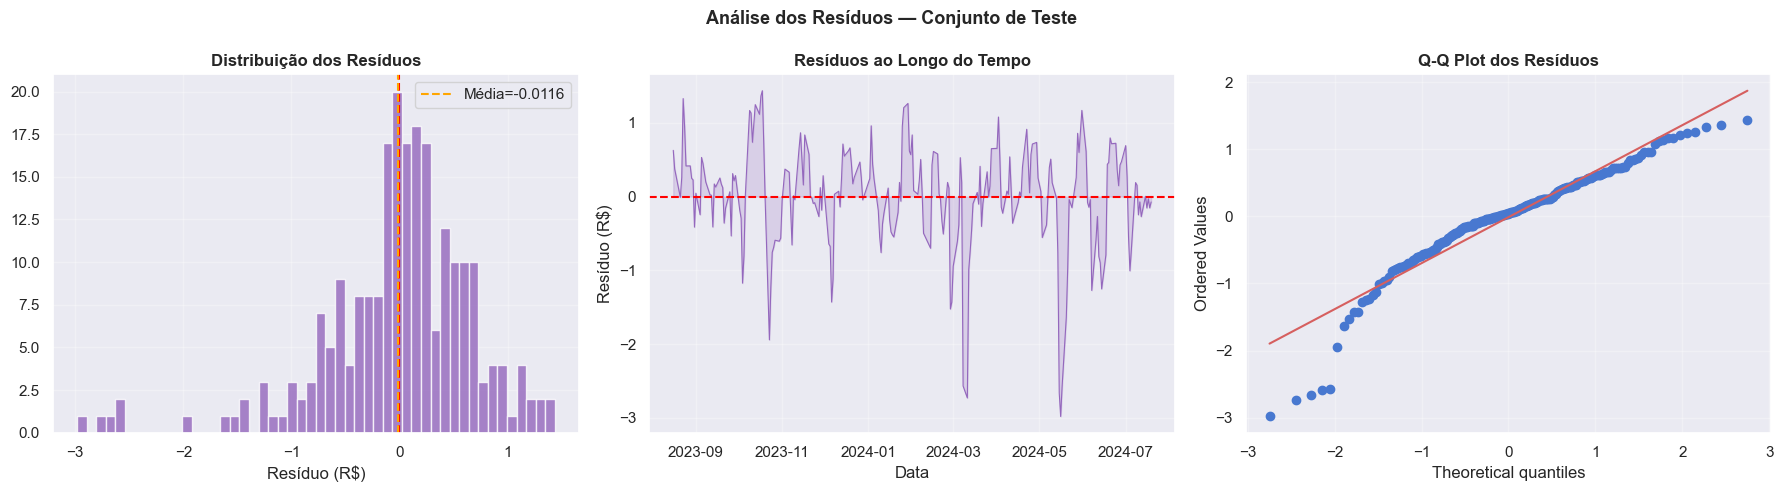

Estatísticas dos resíduos:
  Média:    -0.0116 R$
  Mediana:  0.0469 R$
  Std Dev:  0.7086 R$
  Skewness: -1.2536
  Kurtosis: 3.3175


In [27]:
# ── 7.6 Análise dos resíduos ──────────────────────────────────────────────────
residuals = y_test_true[:min_te] - y_test_pred[:min_te]

fig, axes = plt.subplots(1, 3, figsize=(18, 5))

# Distribuição dos resíduos
axes[0].hist(residuals, bins=50, color='#9467bd', edgecolor='white', alpha=0.8)
axes[0].axvline(0, color='red', linestyle='--', linewidth=1.5)
axes[0].axvline(residuals.mean(), color='orange', linestyle='--', linewidth=1.5,
                label=f'Média={residuals.mean():.4f}')
axes[0].set_title('Distribuição dos Resíduos', fontweight='bold')
axes[0].set_xlabel('Resíduo (R$)')
axes[0].legend()
axes[0].grid(True, alpha=0.3)

# Resíduos ao longo do tempo
axes[1].plot(dates_test[:min_te], residuals, color='#9467bd', linewidth=0.8)
axes[1].axhline(0, color='red', linestyle='--', linewidth=1.5)
axes[1].fill_between(dates_test[:min_te], residuals, 0, alpha=0.2, color='#9467bd')
axes[1].set_title('Resíduos ao Longo do Tempo', fontweight='bold')
axes[1].set_xlabel('Data')
axes[1].set_ylabel('Resíduo (R$)')
axes[1].grid(True, alpha=0.3)

# Q-Q plot
sp_stats.probplot(residuals, dist='norm', plot=axes[2])
axes[2].set_title('Q-Q Plot dos Resíduos', fontweight='bold')
axes[2].grid(True, alpha=0.3)

plt.suptitle('Análise dos Resíduos — Conjunto de Teste', fontweight='bold', fontsize=13)
plt.tight_layout()
plt.show()

print(f'Estatísticas dos resíduos:')
print(f'  Média:    {residuals.mean():.4f} R$')
print(f'  Mediana:  {np.median(residuals):.4f} R$')
print(f'  Std Dev:  {residuals.std():.4f} R$')
print(f'  Skewness: {pd.Series(residuals).skew():.4f}')
print(f'  Kurtosis: {pd.Series(residuals).kurt():.4f}')


---
## 8. Salvamento e Exportação do Modelo <a id='8-salvamento'></a>

In [28]:
# ── 8.1 Salvar Modelo e Artefatos ─────────────────────────────────────────────
os.makedirs('../models', exist_ok=True)

# 1. Modelo Keras
model_path = '../models/lstm_petr4_final.keras'
model.save(model_path)
print(f'Modelo Keras salvo em: {model_path}')

# 2. Metadados
model_metadata = {
    'symbol'          : SYMBOL,
    'start_date'      : START_DATE,
    'end_date'        : END_DATE,
    'look_back'       : LOOK_BACK,
    'normalization'   : 'per-window (divide by first element of window)',
    'feature'         : 'Close price (normalized)',
    'target'          : 'Close[t] / Close[t - look_back]  (ratio ~ 1.0)',
    'reconstruction'  : 'pred_price = y_pred * ref  where ref = Close[t - look_back]',
    'architecture'    : 'LSTM(128) -> LSTM(64) -> Dense(32) -> Dense(1)',
    'loss_function'   : 'Huber',
    'optimizer'       : 'Adam (lr=1e-3, clipnorm=1.0)',
    'batch_size'      : BATCH_SIZE,
    'epochs_total'    : EPOCHS,
    'epochs_trained'  : len(history.history['loss']),
    'metrics_test'    : {k: round(float(v), 6) for k, v in metrics_test.items()},
    'train_split'     : '70%',
    'val_split'       : '15%',
    'test_split'      : '15%',
    'created_at'      : datetime.now().isoformat(),
    'tf_version'      : tf.__version__,
}

metadata_path = '../models/model_metadata.json'
with open(metadata_path, 'w', encoding='utf-8') as f:
    json.dump(model_metadata, f, indent=2, ensure_ascii=False)
print(f'Metadados salvos em: {metadata_path}')

print('\n=== Metadados do Modelo ===')
for k, v in model_metadata.items():
    print(f'  {k:<20}: {v}')


Modelo Keras salvo em: ../models/lstm_petr4_final.keras
Metadados salvos em: ../models/model_metadata.json

=== Metadados do Modelo ===
  symbol              : PETR4.SA
  start_date          : 2018-01-01
  end_date            : 2024-07-20
  look_back           : 60
  normalization       : per-window (divide by first element of window)
  feature             : Close price (normalized)
  target              : Close[t] / Close[t - look_back]  (ratio ~ 1.0)
  reconstruction      : pred_price = y_pred * ref  where ref = Close[t - look_back]
  architecture        : LSTM(128) -> LSTM(64) -> Dense(32) -> Dense(1)
  loss_function       : Huber
  optimizer           : Adam (lr=1e-3, clipnorm=1.0)
  batch_size          : 32
  epochs_total        : 150
  epochs_trained      : 150
  metrics_test        : {'MAE': 0.500759, 'RMSE': 0.708671, 'MAPE': 1.831505, 'R2': 0.935971}
  train_split         : 70%
  val_split           : 15%
  test_split          : 15%
  created_at          : 2026-02-18T16:30:20.

In [29]:
# ── 8.2 Verificar arquivos gerados ────────────────────────────────────────────
print('=== Arquivos do modelo ===')
for f in os.listdir('../models'):
    fpath = os.path.join('../models', f)
    size  = os.path.getsize(fpath) / 1024
    print(f'  {f:<40} {size:>10.1f} KB')

=== Arquivos do modelo ===
  model_metadata.json                             0.8 KB
  scaler_petr4.pkl                                0.7 KB
  lstm_petr4_final.keras                       1432.6 KB
  feat_scaler_petr4.pkl                           0.6 KB
  lstm_petr4_best.keras                        1432.6 KB
  target_scaler_petr4.pkl                         0.5 KB


In [30]:
# ── 8.3 Teste de Inferência com Modelo Carregado ─────────────────────────────
from tensorflow.keras.models import load_model

model_loaded = load_model(model_path)

# Montar última janela normalizada
last_window_raw = close_prices[-(LOOK_BACK + 1) : -1]   # [LOOK_BACK, 1]
ref_price       = last_window_raw[0, 0]                  # primeiro da janela
last_window_norm = (last_window_raw / ref_price).reshape(1, LOOK_BACK, 1)

# Prever ratio normalizado
pred_ratio  = model_loaded.predict(last_window_norm, verbose=0)[0, 0]
pred_price  = pred_ratio * ref_price

last_real_price = df['Close'].iloc[-1]

print(f'Teste de inferência (modelo carregado do disco):')
print(f'  Preço de referência (início da janela) : R$ {ref_price:.4f}')
print(f'  Último preço real                      : R$ {last_real_price:.4f}  ({df.index[-1].date()})')
print(f'  Ratio previsto                         : {pred_ratio:.6f}')
print(f'  Previsão próximo dia                   : R$ {pred_price:.4f}')
print(f'  Variação estimada                      : {((pred_price/last_real_price)-1)*100:.2f}%')
print()
print('Modelo pronto para deploy via API (FastAPI/Flask).')


Teste de inferência (modelo carregado do disco):
  Preço de referência (início da janela) : R$ 30.2122
  Último preço real                      : R$ 31.2928  (2024-07-19)
  Ratio previsto                         : 1.038158
  Previsão próximo dia                   : R$ 31.3650
  Variação estimada                      : 0.23%

Modelo pronto para deploy via API (FastAPI/Flask).


___